# Simple Linear Regression

## Import Libraries

In [18]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

## Prepare the dataset

### Load the dataset

In [19]:
data = pd.read_csv('dataset.csv')
data

,Midterm,Final
0,78,66
1,83,73
2,56,76
3,67,65
4,85,81
5,44,54
6,32,29
7,90,85


### Numpy -> Tensor

In [20]:
X = data.drop(columns=['Final']).values
y = data['Final'].values

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (8, 1)
y shape: (8,)


In [21]:
X = torch.IntTensor(X)
y = torch.IntTensor(y).reshape(-1, 1)

## Plot the dataset

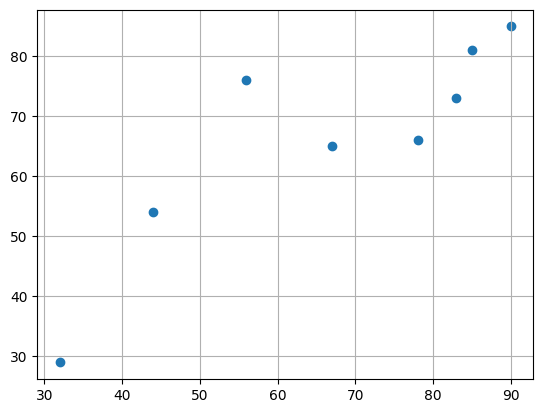

In [22]:
plt.scatter(X, y)
plt.grid(True)
plt.show()

## If midterm score is 71, what is final exam score?